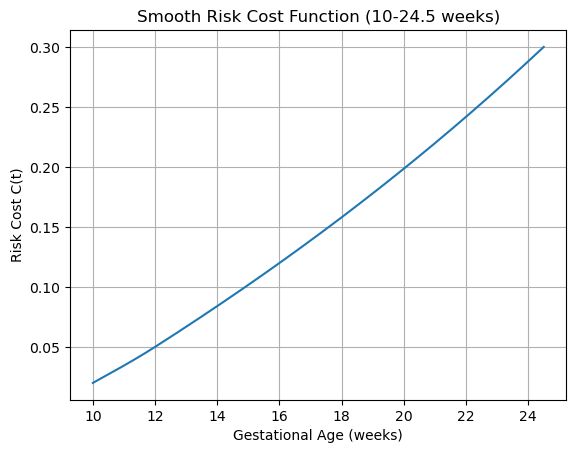

In [7]:
import pandas as pd
import numpy as np
from statsmodels.regression.mixed_linear_model import MixedLM
from lifelines import CoxTimeVaryingFitter
from scipy.stats import norm
import matplotlib.pyplot as plt


df = pd.read_excel("filtered-ref-converted.xlsx")  # 你的 df


from scipy.interpolate import PchipInterpolator

# 风险成本
t_points = [10, 12, 24.5]

# 对应风险成本（可按中值或上界设定）
C_points = [0.02, 0.05, 0.30]  # 这里用小数表示 4%, 6%, 15%

# 构建 PCHIP 光滑插值
risk_cost = PchipInterpolator(t_points, C_points)

# 测试绘图
t = np.linspace(10, 24.5, 500)
C = risk_cost(t)

t = np.linspace(10, 24.5, 500)
C = risk_cost(t)

plt.plot(t, C)
plt.xlabel("Gestational Age (weeks)")
plt.ylabel("Risk Cost C(t)")
plt.title("Smooth Risk Cost Function (10-24.5 weeks)")
plt.grid(True)
plt.show()



E:\anacoda\envs\pytorch\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
E:\anacoda\envs\pytorch\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
E:\anacoda\envs\pytorch\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


            Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   logY     
No. Observations:   889       Method:               REML     
No. Groups:         266       Scale:                0.0474   
Min. group size:    1         Log-Likelihood:       -323.6367
Max. group size:    8         Converged:            Yes      
Mean group size:    3.3                                      
-------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept          -2.314    0.334 -6.925 0.000 -2.968 -1.659
gest_week           0.041    0.004 11.110 0.000  0.033  0.048
BMI                -0.023    0.008 -2.764 0.006 -0.039 -0.007
age                -0.010    0.007 -1.432 0.152 -0.025  0.004
id Var              0.530    0.434                           
id x gest_week Cov -0.020    0.020                           
gest_week Var       

<lifelines.CoxTimeVaryingFitter: fitted with 588 periods, 250 subjects, 559 events>
         event col = 'event'
number of subjects = 250
 number of periods = 588
  number of events = 559
partial log-likelihood = -2629.81
  time fit was run = 2025-09-06 09:36:04 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
logY_pred  -7.36       0.00       0.66            -8.64            -6.07                 0.00                 0.00
BMI        -0.19       0.83       0.02            -0.23            -0.14                 0.80                 0.87
age        -0.09       0.92       0.01            -0.11            -0.06                 0.89                 0.94

            cmp to      z      p   -log2(p)
covariate                                  
logY_pred     0.00 -11.20 <0.005      94.29
BMI           0.00  -8.76 <0.005      58.80
age           0.00  -6.62 <0.005      34.71
---
Partial AIC = 5265.62
log-likelihood ratio test = 116.70 on 3 df
-log2(p) of ll-ratio test = 81.06

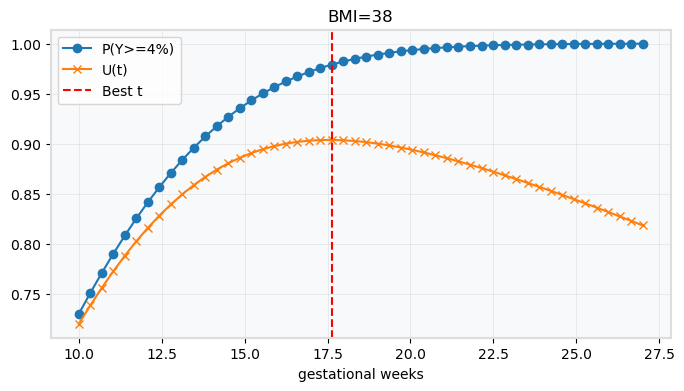

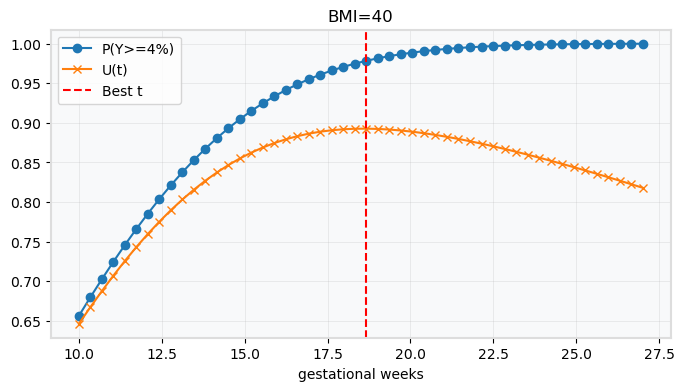

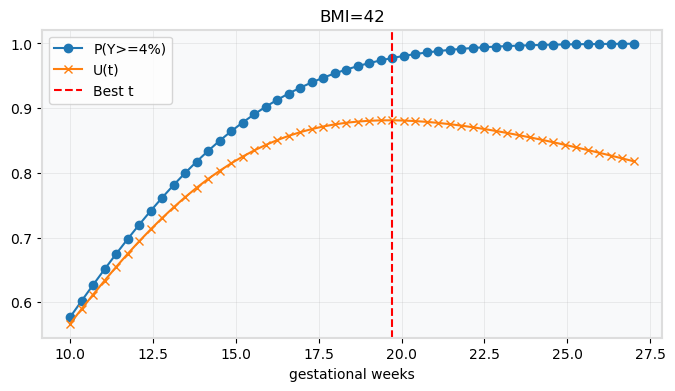

最佳 NIPT 时点 (每组 BMI)： {38: 17.632653061224488, 40: 18.6734693877551, 42: 19.714285714285715}


In [10]:


# 对每个孕妇，记录第一次 Y浓度 >= 0.04 的孕周
threshold = 0.04
surv_list = []

for pid, g in df.groupby('孕妇代码'):
    # 纵向
    g_sorted = g.sort_values('孕周')
    event_mask = g_sorted['Y染色体浓度'] >= threshold
    if event_mask.any():
        time_event = g_sorted.loc[event_mask, '孕周'].iloc[0]
        event = 1
    else:
        time_event = g_sorted['孕周'].max()
        event = 0
    # 生存表
    surv_list.append({
        'id': pid,
        'time': time_event,
        'event': event,
        'BMI': g_sorted['孕妇BMI'].iloc[0],
        'age': g_sorted['年龄'].iloc[0],
        'height': g_sorted['身高'].iloc[0],
        'weight': g_sorted['体重'].iloc[0]
    })
surv_df = pd.DataFrame(surv_list)

# 纵向表
# 创建 long_df 时重命名列
long_df = df[['孕妇代码', '孕周', '孕妇BMI', '年龄', 'Y染色体浓度']].copy()
long_df.rename(columns={
    '孕妇代码': 'id',
    '孕周': 'gest_week',
    '年龄': 'age',
    'Y染色体浓度': 'Yconc',
    '孕妇BMI':'BMI',
}, inplace=True)

# log-transform
long_df['logY'] = np.log(long_df['Yconc'] + 1e-6)



# ------------------------------
# 2. MixedLM 拟合纵向模型
# ------------------------------
md = MixedLM.from_formula(
    "logY ~ gest_week + BMI + age",
    groups="id",
    re_formula="~gest_week",
    data=long_df
)
lme_res = md.fit()
print(lme_res.summary())

# ------------------------------
# 3. Two-stage 联合建模（时间依赖协变量 Cox）
# ------------------------------
# 1. 生成预测
pred_long = []
for pid, sub in long_df.groupby('id'):
    sub = sub.copy()
    try:
        sub['logY_pred'] = lme_res.predict(sub)
    except Exception as e:
        print(f"Predict error for id {pid}: {e}")
        sub['logY_pred'] = np.nan
    pred_long.append(sub)
pred_long = pd.concat(pred_long, ignore_index=True)

# 2. 检查 NaN/Inf 并处理
pred_long['logY_pred'].replace([np.inf, -np.inf], np.nan, inplace=True)
print("预测包含 NaN 的行数：", pred_long['logY_pred'].isna().sum())
print("预测包含 inf 的行数：", np.isinf(pred_long['logY_pred']).sum())

# 3. 按 id 插值
pred_long = pred_long.sort_values(['id', 'gest_week'])
pred_long['logY_pred'] = pred_long.groupby('id')['logY_pred'].transform(
    lambda s: s.interpolate(limit_direction='both')
)

# 4. 填充残余 NaN（组内均值 -> 全局均值）
num_na_remain = pred_long['logY_pred'].isna().sum()
if num_na_remain > 0:
    pred_long['logY_pred'] = pred_long.groupby('id')['logY_pred'].transform(lambda s: s.fillna(s.mean()))
    pred_long['logY_pred'].fillna(pred_long['logY_pred'].mean(), inplace=True)
print("插值后残余 NaN 行数：", pred_long['logY_pred'].isna().sum())



tv_list = []
for pid, sub in pred_long.groupby('id'):
    sub = sub.sort_values('gest_week').reset_index(drop=True)
    surv_row = surv_df[surv_df['id']==pid].iloc[0]
    event_time = surv_row['time']
    event_flag = surv_row['event']
    
    if event_flag == 1:
        event_idx = sub[sub['gest_week'] >= event_time].index.min()
    else:
        event_idx = None
    
    for i in range(len(sub)-1):
        start = sub.loc[i, 'gest_week']
        stop  = sub.loc[i+1, 'gest_week']
        if event_idx is not None and i == event_idx - 1:
            event = 1
        else:
            event = 0
            
        # 事件发生在该区间及之前
        event = int(event_flag==1 and event_time <= stop)
        tv_list.append({
            'id': pid,
            'start': start,
            'stop': stop,
            'event': event,
            'logY_pred': sub.loc[i, 'logY_pred'],
            'BMI': surv_row['BMI'],
            'age': surv_row['age']
        })

tv_df = pd.DataFrame(tv_list)

tv_df = tv_df[tv_df['stop'] > tv_df['start']].copy()

# 合并重复行
tv_df = tv_df.groupby(['id','start','stop']).last().reset_index()

# 确保 event 为整数
tv_df['event'] = tv_df['event'].fillna(0).astype(int)

# Cox 时间依赖拟合
ctv = CoxTimeVaryingFitter()
ctv.fit(tv_df, id_col='id', start_col='start', stop_col='stop', event_col='event')
ctv.print_summary()



# ------------------------------
# 4. 最佳 NIPT 时点计算
# ------------------------------
t_grid = np.linspace(10, 27, 50)
lam = 0.5

best_t_per_BMI = {}
for bmi_group in [38, 40, 42]:  # 高 BMI 分组示例
    U_vals, P_vals = [], []
    for t in t_grid:
        X = pd.DataFrame({"gest_week":[t], "BMI":[bmi_group], "age":[30], "id":[0]})
        mu = lme_res.predict(X)[0]
        sigma = lme_res.scale ** 0.5
        prob = 1 - norm.cdf(np.log(threshold), mu, sigma)
        # 风险成本
        C = risk_cost(t)
        
        U = prob - lam * C
        U_vals.append(U)
        P_vals.append(prob)
    best_idx = np.argmax(U_vals)
    best_t_per_BMI[bmi_group] = t_grid[best_idx]
    
    
    
    # 绘图
    plt.figure(figsize=(8,4))
    plt.plot(t_grid, P_vals, '-o', label='P(Y>=4%)')
    plt.plot(t_grid, U_vals, '-x', label='U(t)')
    plt.axvline(t_grid[best_idx], color='r', linestyle='--', label='Best t')
    plt.title(f'BMI={bmi_group}')
    plt.xlabel('gestational weeks')
    plt.legend()
    
    # 设置网格和样式
    plt.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    plt.gca().set_facecolor('#F8F9FA')
    
    # 美化边框
    for spine in plt.gca().spines.values():
        spine.set_linewidth(1.5)
        spine.set_color('#DDDDDD')
    
    plt.show()

print("最佳 NIPT 时点 (每组 BMI)：", best_t_per_BMI)


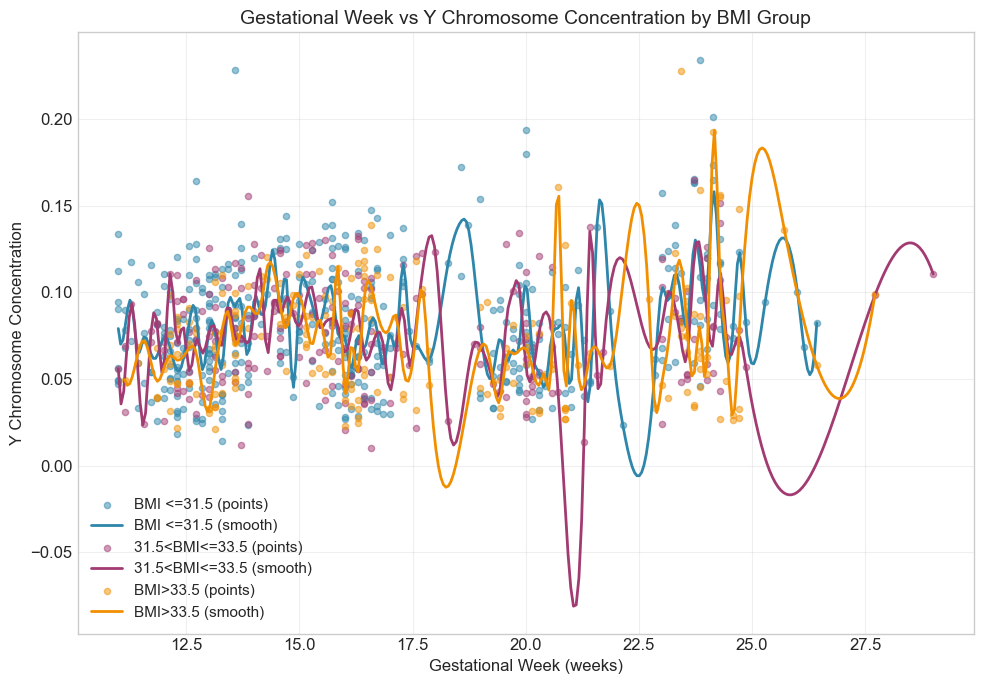

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import make_interp_spline

# 样式设置
sns.set_style("whitegrid")
sns.set_palette("Set2")
plt.rcParams['font.size'] = 12

# --------------------------
# 假设 long_df 已经存在，包含列 ['gest_week', 'Yconc', 'BMI']
# --------------------------
# BMI 分组
bins = [27.5, 31.5, 33.5, 38]  # 示例分组区间
labels = ['BMI <=31.5', '31.5<BMI<=33.5', 'BMI>33.5']
long_df['BMI_group'] = pd.cut(long_df['BMI'], bins=bins, labels=labels, include_lowest=True)

# 绘图
fig, ax = plt.subplots(figsize=(10, 7))
colors = ['#2E86AB', '#A23B72', '#F18F01']

for i, grp in enumerate(labels):
    sub = long_df[long_df['BMI_group'] == grp]
    if sub.empty:
        continue

    # 散点
    ax.scatter(sub['gest_week'], sub['Yconc'], alpha=0.5, s=20,
               color=colors[i], label=f"{grp} (points)")

    # 平滑曲线：先对孕周聚合，避免重复 x
    sub_grouped = sub.groupby("gest_week")["Yconc"].mean().reset_index()
    weeks = sub_grouped["gest_week"].values
    yvals = sub_grouped["Yconc"].values

    if len(weeks) >= 4:  # 样条至少 4 个点
        xnew = np.linspace(weeks.min(), weeks.max(), 300)
        spline = make_interp_spline(weeks, yvals, k=3)
        y_smooth = spline(xnew)
        ax.plot(xnew, y_smooth, color=colors[i], linewidth=2, label=f"{grp} (smooth)")

# 标签与标题
ax.set_xlabel("Gestational Week (weeks)", fontsize=12)
ax.set_ylabel("Y Chromosome Concentration", fontsize=12)
ax.set_title("Gestational Week vs Y Chromosome Concentration by BMI Group", fontsize=14)
ax.legend(loc="best", fontsize=11)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [20]:
md = MixedLM.from_formula(
    "logY ~ np.power(gest_week,2) + BMI + age",
    groups="id",
    re_formula="~gest_week",
    data=long_df
)


import statsmodels.api as sm
sm.qqplot(lme_res.resid, line='45')
plt.show()
sns.histplot(lme_res.random_effects.values(), kde=True)
plt.show()


ValueError: could not convert string to float: 'A264'